In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam 
from pyro.infer import Predictive

from utils import *

In [2]:
def model2(game_info, obs=None):
    """
    Inputs: 
        obs: A 1D tensor of observed data. The length should be equal to the number of games played.
             Represents the outcome of a game in the eyes of coach 1, i.e. coach 1 wins: obs = 1, coach 2 wins: obs = -1.

    Output: A 1D tensor of the same length as the input tensor. Represents a sample from difference in performance between the two coaches.
    """
    
    hyper_sigma = 1/8 # consider if this variable is maintained constant during inference.
    # do we want it to be constant?
    
    coach1_mu_skill = 0
    coach1_sigma_skill = 1
    coach1_skill = pyro.sample("coach1_skill", dist.Normal(coach1_mu_skill, coach1_sigma_skill))
    coach2_mu_skill = 0
    coach2_sigma_skill = 1
    coach2_skill = pyro.sample("coach2_skill", dist.Normal(coach2_mu_skill, coach2_sigma_skill))
    
    with pyro.plate('matches', obs.shape[0]):   

        coach1_perf = pyro.sample('coach1_perf', dist.Normal(coach1_skill, hyper_sigma))
        coach2_perf = pyro.sample('coach2_perf', dist.Normal(coach2_skill, hyper_sigma))

        perf_diff = coach1_perf - coach2_perf
    
        y = pyro.sample("y_coach1_win", dist.Normal(perf_diff, hyper_sigma), obs=obs)

    return y

# Training on fake data where coach 1 always wins.

In [3]:
# train the model on fake data where coach 1 always wins.
num_games = 100
game_info = {}
obs = torch.ones(num_games)

guide = AutoNormal(model2)
run_inference(model2, guide, game_info, obs)

Loss = -32.559512: 100%|██████████| 2000/2000 [00:21<00:00, 91.38it/s] 


In [4]:
predictive = Predictive(model2, guide=guide, num_samples=2000, return_sites=("coach1_skill", "coach2_skill"))

samples = predictive(game_info, obs)

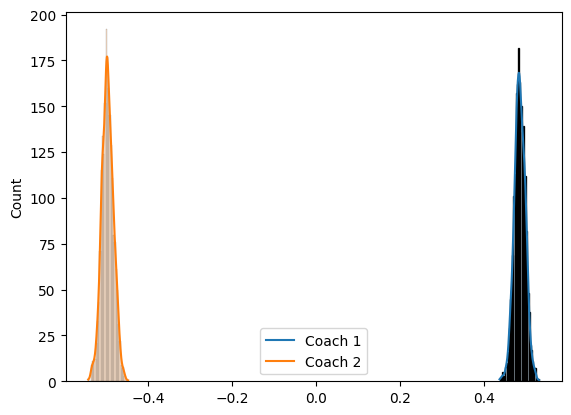

In [5]:
import seaborn as sns

#Plotting the data
coach1_skill_inf = samples["coach1_skill"].detach().squeeze()
coach2_skill_inf= samples["coach2_skill"].detach().squeeze()

sns.histplot(coach1_skill_inf, kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf, kde=True, alpha=0.2)
plt.legend(["Coach 1", "Coach 2"])
plt.show()

# Training on fake data where each match is a draw.

In [6]:
obs = torch.zeros(num_games)

guide = AutoNormal(model2)
run_inference(model2, guide, game_info, obs)

Loss = -32.660073: 100%|██████████| 2000/2000 [00:20<00:00, 95.60it/s] 


In [7]:
predictive = Predictive(model2, guide=guide, num_samples=2000, return_sites=("coach1_skill", "coach2_skill"))

samples = predictive(game_info, obs)

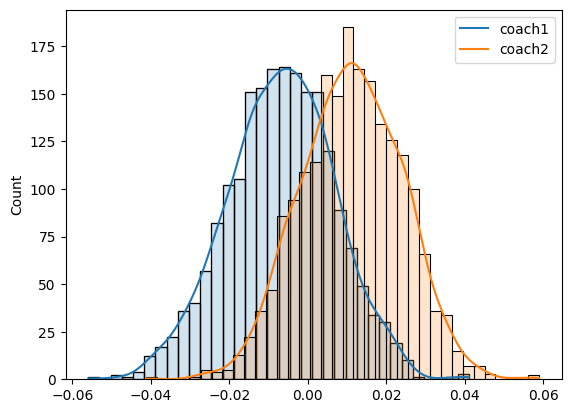

In [8]:
#Plotting the data
coach1_skill_inf = samples["coach1_skill"].detach().squeeze()
coach2_skill_inf= samples["coach2_skill"].detach().squeeze()

sns.histplot(coach1_skill_inf, kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf, kde=True, alpha=0.2)
plt.legend(["coach1", "coach2"])
plt.show()

# Training on fake data where coach 2 always wins.

In [9]:
obs = -torch.ones(num_games)

guide = AutoNormal(model2)
run_inference(model2, guide, game_info, obs)

Loss = -22.307132: 100%|██████████| 2000/2000 [00:19<00:00, 105.16it/s]


In [10]:
predictive = Predictive(model2, guide=guide, num_samples=2000, return_sites=("coach1_skill", "coach2_skill"))

samples = predictive(game_info, obs)

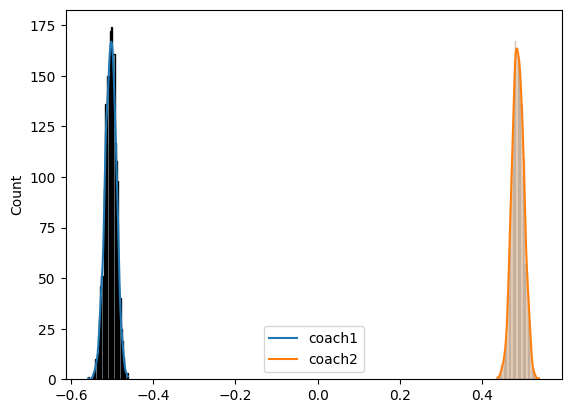

In [11]:
#Plotting the data
coach1_skill_inf = samples["coach1_skill"].detach().squeeze()
coach2_skill_inf= samples["coach2_skill"].detach().squeeze()

sns.histplot(coach1_skill_inf, kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf, kde=True, alpha=0.2)
plt.legend(["coach1", "coach2"])
plt.show()

# Comparing distributions from fake data based on number of games played.

In [12]:
optimizer = Adam({"lr": 0.01})

# variables to save results
coach1_skill_inf = np.empty((3, 2000))
coach2_skill_inf = np.empty((3, 2000))

for i in range(1,4):
    pyro.clear_param_store()

    # Training loop
    num_steps = 100
    num_games = 10**i

    guide = AutoNormal(model2)

    run_inference(model2, guide, game_info, obs)

    predictive = Predictive(model2, guide=guide, num_samples=2000,
                            return_sites=("coach1_skill", "coach2_skill"))

    samples = predictive(game_info, obs)

    coach1_skill_inf[i-1] = samples["coach1_skill"].detach().squeeze()
    coach2_skill_inf[i-1] = samples["coach2_skill"].detach().squeeze()



Loss = -48.794762: 100%|██████████| 2000/2000 [00:20<00:00, 98.69it/s] 


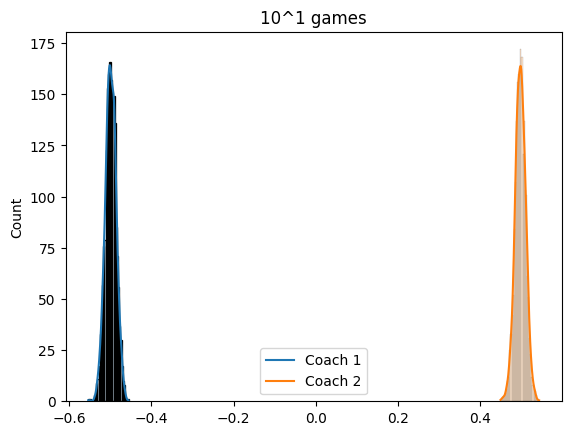

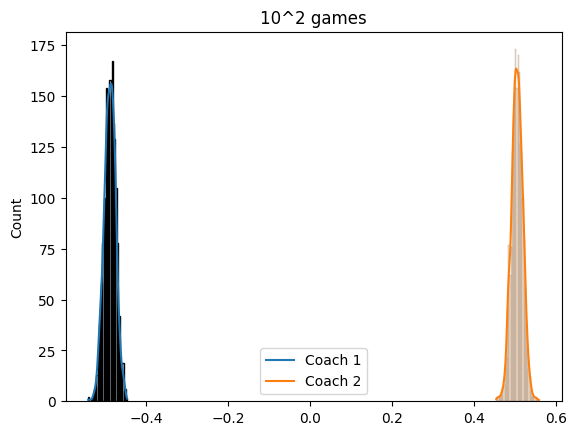

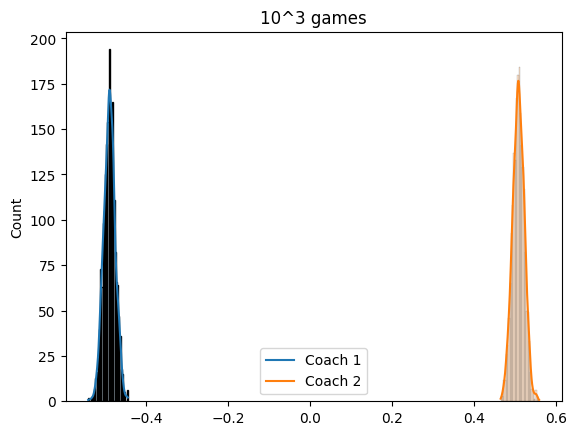

In [13]:
#Plotting the data
sns.histplot(coach1_skill_inf[0], kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf[0], kde=True, alpha=0.2)
plt.title("10^1 games")
plt.legend(["Coach 1", "Coach 2"])
plt.show()

sns.histplot(coach1_skill_inf[1], kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf[1], kde=True, alpha=0.2)
plt.title("10^2 games")
plt.legend(["Coach 1", "Coach 2"])
plt.show()

sns.histplot(coach1_skill_inf[2], kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf[2], kde=True, alpha=0.2)
plt.title("10^3 games")
plt.legend(["Coach 1", "Coach 2"])
plt.show()

# Lets try and make some fake data where coach 1 starts by losing but slowly gets better.

In [14]:
obs1 = -torch.ones(100)
obs2 = torch.zeros(100)
obs3 = torch.ones(200)

obs = torch.cat((obs1, obs2, obs3))

guide = AutoNormal(model2)
run_inference(model2, guide, game_info, obs)

Loss = 2799.650907: 100%|██████████| 2000/2000 [00:20<00:00, 95.43it/s] 


In [17]:
predictive = Predictive(model2, guide=guide, num_samples=2000, return_sites=("coach1_skill", "coach2_skill"))

samples = predictive(game_info, obs)

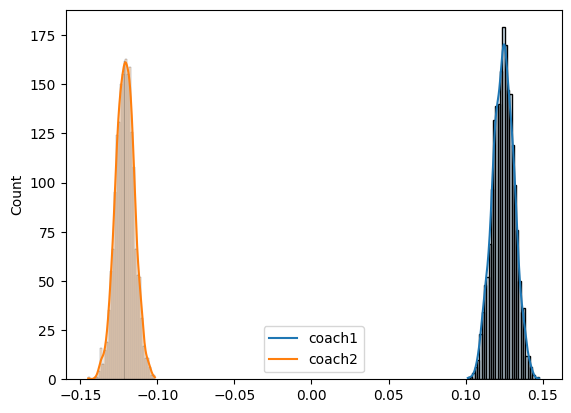

In [ ]:
#Plotting the data
coach1_skill_inf = samples["coach1_skill"].detach().squeeze()
coach2_skill_inf= samples["coach2_skill"].detach().squeeze()

sns.histplot(coach1_skill_inf, kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf, kde=True, alpha=0.2)
plt.legend(["coach1", "coach2"])
plt.show()